# SemanticDraw Multi-Prompt Image Inpainting with Prompt Separation Demo for SD3 (Experimental)


## Preparation

In [1]:
seed = 1
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from functools import reduce

from util import seed_everything, blend
from model import SemanticDraw3Pipeline
from ipython_util import dispt


seed_everything(seed)
device = f'cuda:{device}'
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 1
[INFO] Initialized with device: cuda:0


## Background image to inpaint

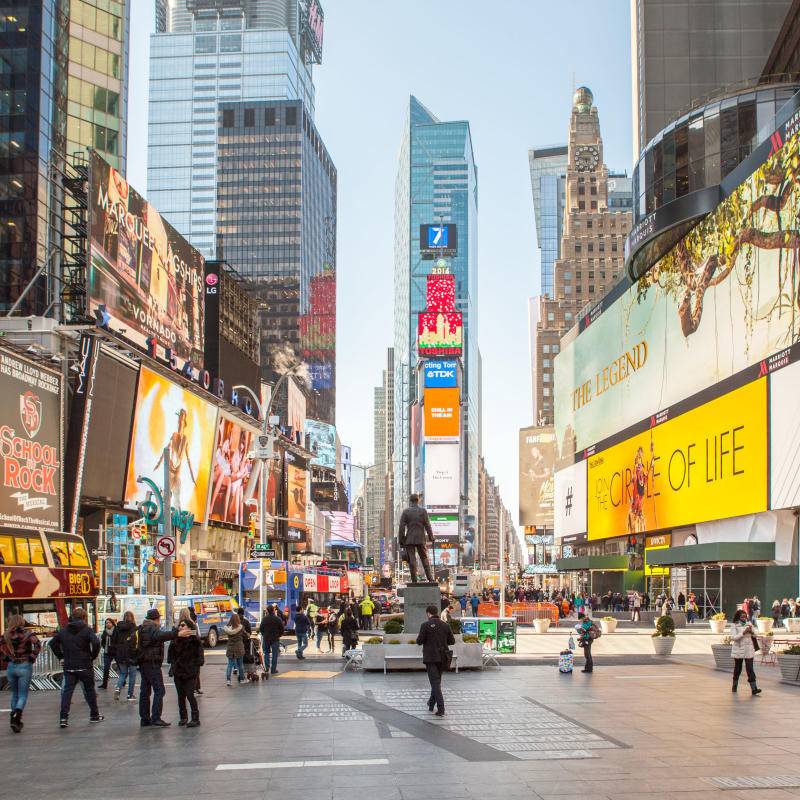

In [3]:
background_image = Image.open('../assets/timessquare/timessquare.jpeg')
display(background_image)

# Run

## Step 1: Load a SemanticDraw pipeline for SD3.

In [4]:
smd = SemanticDraw3Pipeline(device)

[INFO] Loading Stable Diffusion...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 17.92it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


[INFO] Model is loaded!


## Step 2: Load *semantic palette*, i.e., prompts and masks.

The differences of this inpainting example with the generation example in `demo_simple_sdxl.ipynb` are summarized as:

1. In the inpainting mode, we do not explicitly specify background mask. It is calculated in the module.
2. In the inpainting mode, the `background_prompt` and the `background_negative_prompt` are explicitly specified. However, such prompts are not necessary since we use BLIP-2 model internally to estimate the background prompt from the background image.
3. The call of the module receives additional arguments of `background` for background image, in addition to the optional `background_prompt` and `background_negative_prompt`.

[INFO] Loading masks...


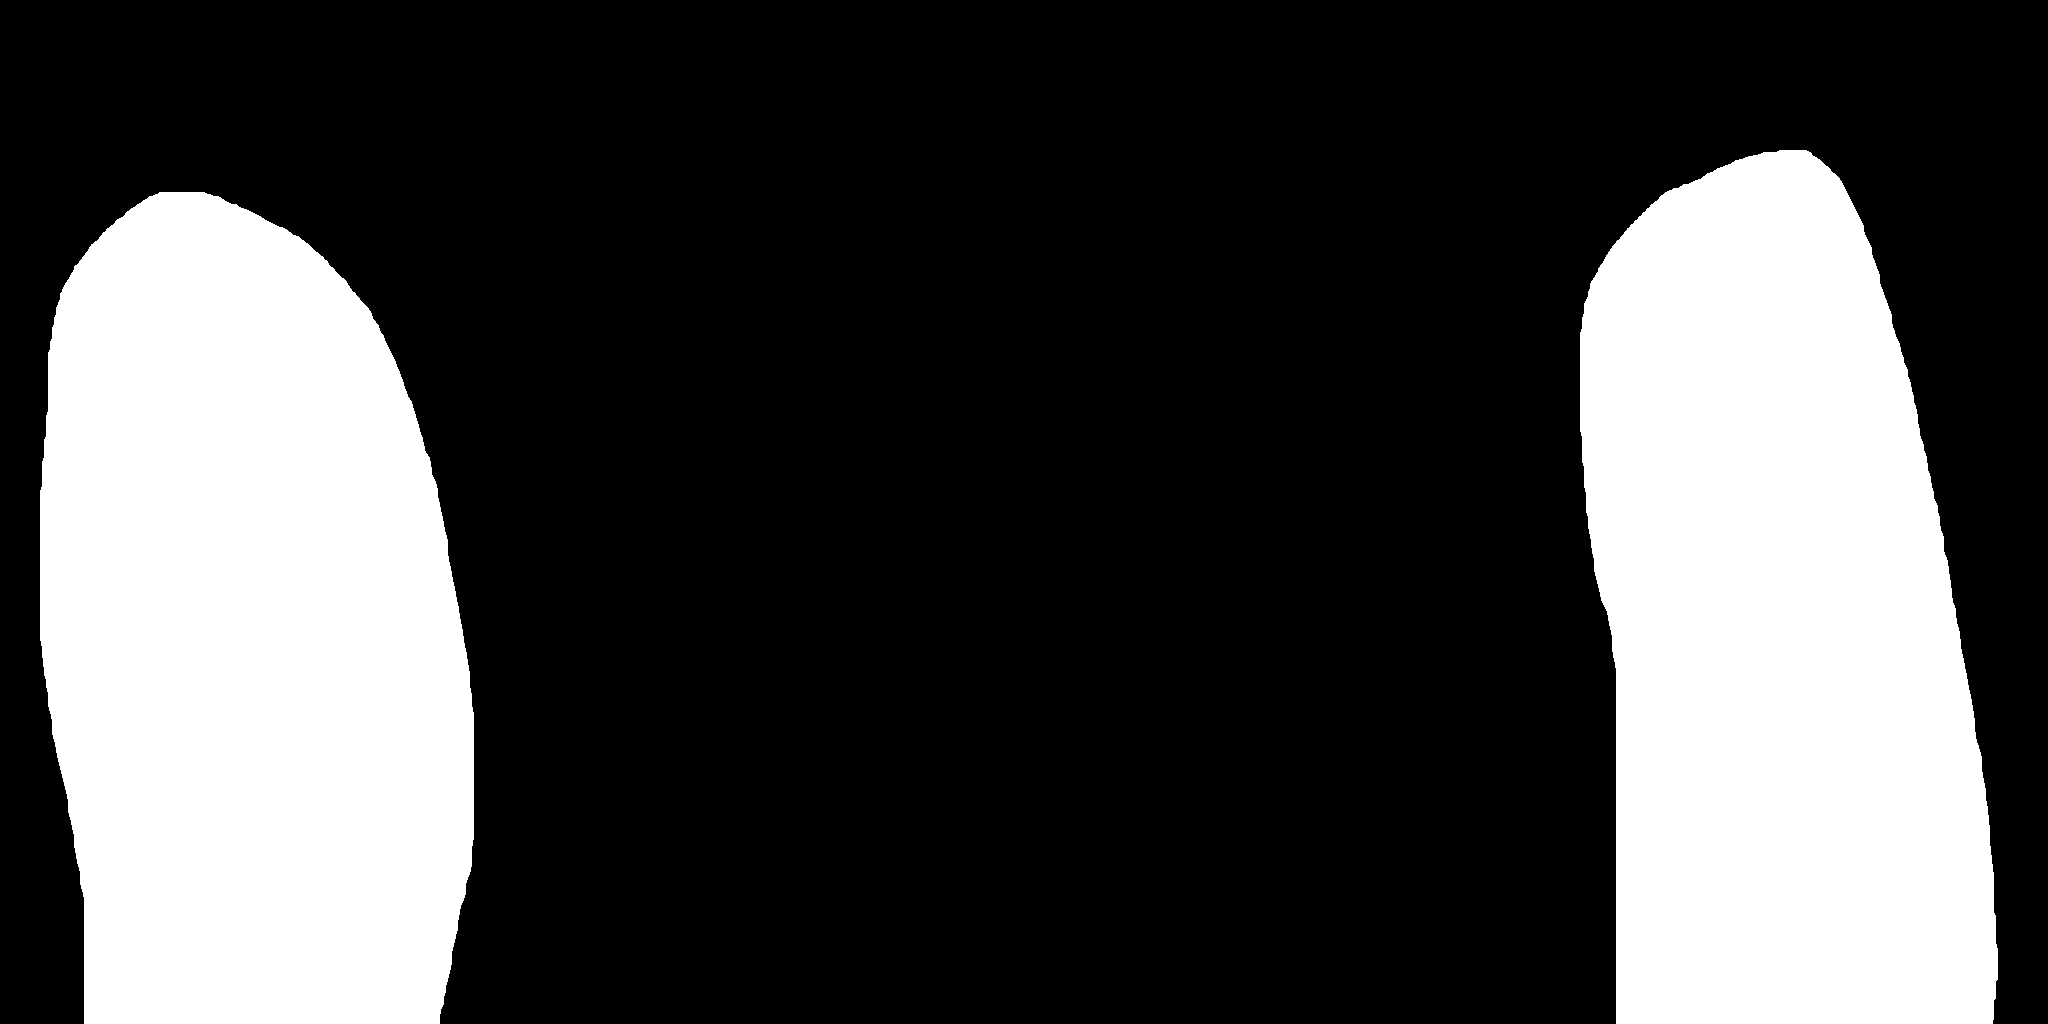

[INFO] Loading prompts...
Background Prompt: 1girl, 1boy, times square
Background Negative Prompt: worst quality, bad quality, normal quality, cropped, framed
Prompt0: a boy standing holding letter "SMD", times square background
Prompt1: a girl standing holding letter "3", times square background
Negative Prompt0: worst quality, bad quality, normal quality, cropped, framed, 
Negative Prompt1: worst quality, bad quality, normal quality, cropped, framed, 


In [5]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'timessquare'
mask_all = Image.open(f'../assets/{name}/{name}_full.png').convert('RGBA').resize((1024, 1024))
masks = [Image.open(f'../assets/{name}/{name}_{i}.png').convert('RGBA').resize((1024, 1024)) for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background mask is not explicitly specified in the inpainting mode.
dispt(masks, row=1)

masks = torch.stack(masks, dim=0)

# Prepare prompts.
print('[INFO] Loading prompts...')

background_prompt = '1girl, 1boy, times square'
prompts = [
    # Foreground prompts.
    'a boy standing holding letter "SMD", times square background',
    'a girl standing holding letter "3", times square background',
]
negative_prompts = [
    '',
    '',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]
background_negative_prompt = negative_prompt_prefix

print('Background Prompt: ' + background_prompt)
print('Background Negative Prompt: ' + background_negative_prompt)
for i, prompt in enumerate(prompts):
    print(f'Prompt{i}: ' + prompt)
for i, prompt in enumerate(negative_prompts):
    print(f'Negative Prompt{i}: ' + prompt)

height, width = masks.shape[-2:]

## Step 3: Do inpainting!

### Main generation routine

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Elapsed Time: 5.9397547245025635


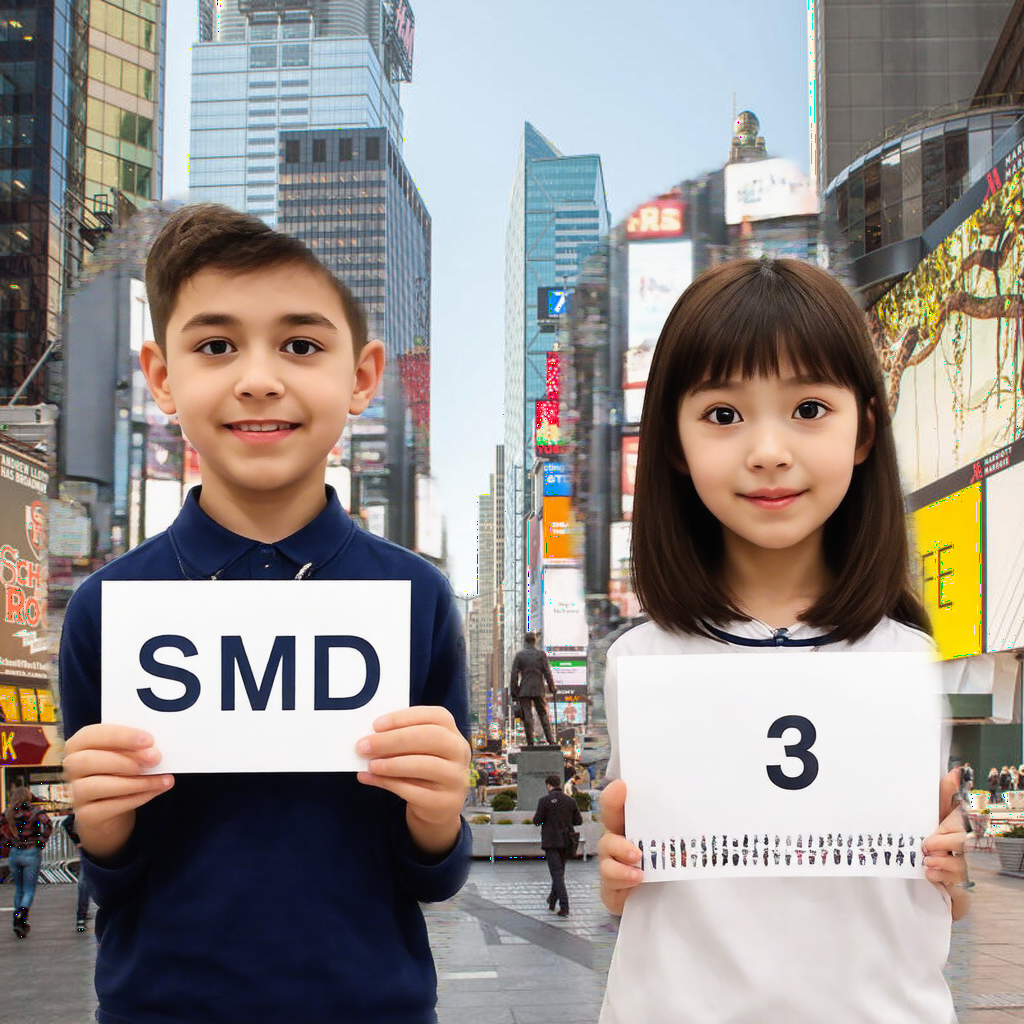

In [6]:
tic = time.time()
img = smd(
    prompts,
    negative_prompts,
    masks=masks.float(),
    guidance_scale=0,
    # Use larger standard deviation to harmonize the inpainting result!
    mask_stds=8,
    mask_strengths=.9,
    height=height,
    width=width,
    bootstrap_steps=2,
    bootstrap_leak_sensitivity=0.1,
    # This is for providing the image input.
    background=background_image,
    background_prompt=background_prompt,
    background_negative_prompt=background_negative_prompt,
)
toc = time.time()
print(f'Elapsed Time: {toc - tic}')
display(img)